In [5]:
import sys
sys.path.append('..')
from tool import *
def fill_albedo2(month,type,sza_L,interp_2000=False):
    max_distance=3
    distence_w_dim=torch.load(root_path+'information_val2/weights.pth')[type]
    sza_L_month=sza_L[0,month-1]
    # distence_w_dim=[1,1,1,1]
    bands=['albedo_BSA_vis', 
        'albedo_WSA_vis', 
        'albedo_BSA_nir', 
        'albedo_WSA_nir', 
        'albedo_BSA_shortwave', 
        'albedo_WSA_shortwave']
    # band='albedo_BSA_vis'

    # m_index=[(month-3)%12+1,(month-2)%12+1,(month-1)%12+1,(month)%12+1,(month+1)%12+1]
    m_index=[(month-2)%12+1,(month-1)%12+1,(month)%12+1]
    offset=[1 if m_index[j]-m_index[0]>=0 else -1 for j in range(len(m_index))]
    if np.array(offset).sum()==len(offset):
        offset=[0]*len(m_index)
    # print(month,m_index,offset)

    vs=[]
    ms=[]
    land_proportions=[]
    for i in range(len(offset)):    
        NC=nc.Dataset(root_path+f'information_val2/month_{m_index[i]}.nc','r')
        for band in bands:
            vs.append(NC.variables[f'{band}-{type}'][:])
        if type!='ocean':
            ms.append(NC.variables[f'area-{type}'][:])
        # qa=NC.variables['qa'][:]
        area_grid=NC.variables['area-grid'][:]
        area_land=NC.variables['area-land'][:]
        land_proportions.append(area_land/area_grid)
        NC.close()
    offset_bands=[]
    for i in offset:
        offset_bands+=[i]*len(bands)
    if offset[0]!=0:
        nan_array=np.zeros((1,180,360))*np.nan
        vs=[np.concatenate((nan_array,vs[i]),axis=0) if offset_bands[i]==1 else np.concatenate((vs[i],nan_array),axis=0) for i in range(len(offset_bands))]
        land_proportions=[np.concatenate((nan_array,land_proportions[i]),axis=0) if offset[i]==1 else np.concatenate((land_proportions[i],nan_array),axis=0) for i in range(len(offset))]
        if type!='ocean':
            ms=[np.concatenate((nan_array,ms[i]),axis=0) if offset[i]==1 else np.concatenate((ms[i],nan_array),axis=0) for i in range(len(offset))]
        else:
            ms=land_proportions  
    else:
        if type=='ocean':
            ms=land_proportions  
    M,H,W=vs[0].shape
    v=np.stack(vs).reshape((len(offset),len(bands),M,H,W)).transpose((1,0,2,3,4))#(6, 3, 21, 180, 360)

    # vv=[v[:,i] for i in range(len(bands))]
    m=np.stack(ms)
    # plt.imshow(v[0,1,1])
    # plt.show()
    # land_proportion=np.stack(land_proportions)
    # print(month,m_index,v.shape)
    all_indices = np.indices(v[0].shape).reshape(4, -1).T
    
    

    
    
    if interp_2000:
        if type!='ocean':
                interp_indices = all_indices[((v[0]==2000) & (m>0)).reshape(-1)]
        else:
            interp_indices = all_indices[((v[0]==2000) & (m<1) & (m>0)).reshape(-1)]
        nonan_indices=all_indices[((~np.isnan(v[0])).reshape(-1)) & ((v[0]!=2000).reshape(-1))]
    else:
    
        if type!='ocean':
            interp_indices = all_indices[(np.isnan(v[0]) & (m>0)).reshape(-1)]
        else:
            interp_indices = all_indices[(np.isnan(v[0]) & (m<1) & (m>0)).reshape(-1)]
        nonan_indices=all_indices[(~np.isnan(v[0])).reshape(-1)]
    
    
    
    
    # print(len(nonan_indices))
    interp_indices=[j for j in interp_indices if j[0]==int(len(offset)/2)]  
    interp_indices=[j for j in interp_indices if sza_L_month[j[2],j[3]]<2] #只插值天顶角小于85的
    nonan_indices2=[j for j in nonan_indices if j[0]==int(len(offset)/2)]  
    nonan_indices2=[j for j in nonan_indices2 if sza_L_month[j[2],j[3]]<2]
    # interp_values=[]
    # search_n=1
    # print(month,type,len(interp_indices),round(len(interp_indices)/(len(nonan_indices)+len(interp_indices))*100,2),'%')
    str_output=f'{month}-{type}  '+str(len(interp_indices))+'  '+str(round(len(interp_indices)/(len(nonan_indices2)+len(interp_indices)+0.01)*100,2))+'%'
    # for interp_indice in tqdm(interp_indices):
    #     k=TS_IDM_4d(interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim)
    #     while np.isnan(k):
    #         search_n*=2
    #         k=TS_IDM_4d(interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim)

    #     interp_values.append(k)
    time.sleep(1)
    kk=[search_nonan2(v,interp_indice,max_distance=max_distance,distence_w_dim=distence_w_dim,interp_2000=interp_2000) for interp_indice in tqdm(interp_indices,desc=str_output)]
    interp_values=np.array([a[0] for a in kk])
    dws=np.array([a[1] for a in kk])
    # print('fill value '+str((1-np.isnan(interp_values).sum()/interp_values.shape[0])*100)+'%')
    dws_v=np.zeros(v.shape)
    for z in range(len(interp_indices)):
        v[:,interp_indices[z][0],interp_indices[z][1],interp_indices[z][2],interp_indices[z][3]]=np.array(interp_values[z])
        dws_v[:,interp_indices[z][0],interp_indices[z][1],interp_indices[z][2],interp_indices[z][3]]=np.array(dws[z])
    # print(v.shape,dws_v.shape)
    if offset[int(len(offset)/2)]>=0:
        return v[:,int(len(offset)/2),offset[int(len(offset)/2)]:],dws_v[:,int(len(offset)/2),offset[int(len(offset)/2)]:]
    else:
        return v[:,int(len(offset)/2),:-1],dws_v[:,int(len(offset)/2),:-1]
def TS_IDM_4d_2(v,interp_indice,max_distance,distence_w_dim,interp_2000):
    
        value=v[zero(interp_indice[0]-int(max_distance/distence_w_dim[0])):interp_indice[0]+int(max_distance/distence_w_dim[0])+1,
                zero(interp_indice[1]-int(max_distance/distence_w_dim[1])):interp_indice[1]+int(max_distance/distence_w_dim[1])+1,
                zero(interp_indice[2]-int(max_distance/distence_w_dim[2])):interp_indice[2]+int(max_distance/distence_w_dim[2])+1,
                zero(interp_indice[3]-int(max_distance/distence_w_dim[3])):interp_indice[3]+int(max_distance/distence_w_dim[3])+1]
        non_nan_indices = np.where(~np.isnan(value))
        
        
        if interp_2000:
            v[v==2000]=np.nan
        
        
        non_nan_points = np.array(list(zip(non_nan_indices[0], non_nan_indices[1], non_nan_indices[2],non_nan_indices[3])))
         
        if len(non_nan_points)==0:
                interpolated_value=np.nan
                dws=np.nan
        else:
                k=np.array([zero(-interp_indice[0]+int(max_distance/distence_w_dim[0]))-int(max_distance/distence_w_dim[0]),
                        zero(-interp_indice[1]+int(max_distance/distence_w_dim[1]))-int(max_distance/distence_w_dim[1]),
                        zero(-interp_indice[2]+int(max_distance/distence_w_dim[2]))-int(max_distance/distence_w_dim[2]),
                        zero(-interp_indice[3]+int(max_distance/distence_w_dim[3]))-int(max_distance/distence_w_dim[3])])
                # print(k)
                # print(non_nan_points)
                non_nan_points+=k
                distance_s = np.array([np.linalg.norm(np.array(non_nan_points[i])*np.array(distence_w_dim)) for i in range(len(non_nan_points))])
                if len(distance_s)<10:
                        interpolated_value=np.nan
                        dws=np.nan
                else:
                        kth = np.partition(distance_s, 9)[9]
                        distance=distance_s.copy()
                        distance1=distance_s.copy()
                        distance1=distance1[distance_s<=kth]
                        weights = 1.0 / distance1**2
                        dws=np.sum(weights)
                        weights /= dws
                        non_nan_values = value[non_nan_indices]
                        non_nan_values=non_nan_values[distance<=kth]
                        interpolated_value = np.sum(weights * non_nan_values)
        return interpolated_value,dws
    
def search_nonan2(v,interp_indice,max_distance,distence_w_dim,interp_2000):
    k_bands=[]
    dws_bands=[]
    search_n=1
    for i in range(6):
        k,dws=TS_IDM_4d_2(v[i],interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim[i],interp_2000=interp_2000)
        while np.isnan(k):
            search_n*=2
            k,dws=TS_IDM_4d_2(v[i],interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim[i],interp_2000=interp_2000)
        k_bands.append(k)
        dws_bands.append(dws)
    
    return k_bands,dws_bands
def zero(k):
    if k<0:
        return 0
    else:
        return k

In [3]:
aaa_pd=pd.read_csv(root_path+'information_temp/nan_coords2.csv')
aaa_pd

,Unnamed: 0,y,m,lon,lat,type,sza,sza_L,main_band1,main_band2,main_band3,main_band4,main_band5,main_band6
0,0,2001,1,100,31,landtype1,51.370184,0.0,20.045990,20.618515,114.11950,116.375984,76.32311,77.71246
1,1,2001,1,-58,-19,landtype1,2.996200,0.0,40.210526,46.000000,157.00000,196.684200,102.68421,125.42105
2,2,2001,1,96,25,landtype1,45.378026,0.0,36.910713,38.982143,178.66072,189.125000,113.50000,119.51786
3,3,2001,1,101,27,landtype1,47.375239,0.0,21.444645,22.585386,130.78479,136.314320,84.61261,87.88188
4,4,2001,1,-83,36,landtype1,56.364630,0.0,37.500000,36.200000,181.40000,177.950000,116.75000,114.60000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538385,95995,2020,12,41,53,snow,75.475947,1.0,697.190300,670.150900,496.03320,462.637100,591.80870,562.22970
538386,95996,2020,12,157,-73,snow,50.541488,0.0,954.744260,956.501340,643.77040,646.128360,808.29755,810.27580
538387,95997,2020,12,-75,-85,snow,62.536635,0.0,989.339050,983.595340,716.94420,696.210300,861.17694,848.35110
538388,95998,2020,12,170,-83,snow,60.537359,0.0,893.873600,889.398300,564.76996,556.376200,740.33580,734.11310


In [4]:
#将验证点的数值设为2000
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
bands=['albedo_BSA_vis', 
'albedo_WSA_vis', 
'albedo_BSA_nir', 
'albedo_WSA_nir', 
'albedo_BSA_shortwave',
'albedo_WSA_shortwave']
for m in range(1,13):
    print(m)
    NC=nc.Dataset(root_path+f'information_val2/month_{m}.nc','r+')
    for landtype in landtypes:
        for band in bands:
            img=NC.variables[f'{band}-{landtype}'][:]
            # aa_type=[[y-2001,90-i[0],i[1]+180] for i in aaa[y] if i[2]==landtype]
            aa_type=aaa_pd[(aaa_pd.type==landtype) & (aaa_pd.m==m)]
            for ind, row in aa_type.iterrows():
                img[row['y']-2001,90-row['lat'],row['lon']+180]=2000
            NC.variables[f'{band}-{landtype}'][:]=img
            NC.sync()
    NC.close()

1
2
3
4
5
6
7
8
9
10
11
12


In [6]:
#fill albedo
bands=['albedo_BSA_vis', 
'albedo_WSA_vis', 
'albedo_BSA_nir', 
'albedo_WSA_nir', 
'albedo_BSA_shortwave',
'albedo_WSA_shortwave']
_,sza_L=torch.load(root_path+'sza_and_szaL.pth')
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
for month in [1,2,3]:
    NC=nc.Dataset(root_path+f'information_val2/month_{month}.nc','r+')
    for type in landtypes:
        v_fill,dws=fill_albedo2(month,type,sza_L,True)
        for band_i in range(len(bands)):
            NC.variables[f'{bands[band_i]}-{type}'][:]=v_fill[band_i]
            try:
                NC.createVariable(f'DWS-{type}-{bands[band_i]}', 'f4', ("time", "latitude", "longitude"))
            except:
                pass
                # print(f'DWS-{type}-{bands[band_i]} have existed')
            NC.variables[f'DWS-{type}-{bands[band_i]}'][:]=dws[band_i]
    NC.close()

1-landtype14  840  1.19%: 100%|██████████| 840/840 [00:17<00:00, 47.88it/s]
1-landtype15  0  0.0%: 0it [00:00, ?it/s]
2-landtype14  956  1.36%: 100%|██████████| 956/956 [00:18<00:00, 51.16it/s]
2-landtype15  0  0.0%: 0it [00:00, ?it/s]
2-snow  7818  2.57%: 100%|██████████| 7818/7818 [02:23<00:00, 54.57it/s]


In [23]:
#添加验证点的ground truth
aaa2=[]
aaa_pd=pd.read_csv(root_path+'information_val2/nan_coords2.csv')
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']

bands=['albedo_BSA_vis', 
    'albedo_WSA_vis', 
    'albedo_BSA_nir', 
    'albedo_WSA_nir', 
    'albedo_BSA_shortwave', 
    'albedo_WSA_shortwave']

for m in range(1,13):
    print(m)
    NC=nc.Dataset(root_path+f'information_temp/month_{m}.nc','r')
    for landtype in landtypes:
        kk={}
        aa_type=aaa_pd[(aaa_pd.type==landtype) & (aaa_pd.m==m)]
        n=0
        for band in bands:
            img=NC.variables[f'{band}-{landtype}'][:]
            # aa_type=[[y-2001,90-i[0],i[1]+180] for i in aaa[y] if i[2]==landtype]
            kk[band]=[]
            for ind, row in aa_type.iterrows():
                kk[band].append(img[row['y']-2001,90-row['lat'],row['lon']+180])
            n+=1
            aa_type[f'pred_band{n}']=kk[band]
        aaa2.append(aa_type)
    NC.close()
aaa_pd2=pd.concat(aaa2)
aaa_pd2.to_csv(root_path+'information_val2/nan_coords2.csv')

1
2
3
4
5
6
7
8
9
10
11
12


In [18]:
aaa_pd2=pd.read_csv(root_path+'information_val2/nan_coords2.csv')

In [12]:
from sklearn.metrics import r2_score,mean_squared_error
bands=['albedo_Black-sky_visible', 
    'albedo_White-sky_visible', 
    'albedo_Black-sky_near-infrared', 
    'albedo_White-sky_near-infrared', 
    'albedo_Black-sky_shortwave', 
    'albedo_White-sky_shortwave']
print('band    R2    RMSE')
for n in range(1,7):
    r2=r2_score(np.array(aaa_pd2[f'main_band{n}'])/1000,np.array(aaa_pd2[f'pred_band{n}'])/1000)
    rmse=np.sqrt(mean_squared_error(np.array(aaa_pd2[f'main_band{n}'])/1000,np.array(aaa_pd2[f'pred_band{n}'])/1000))
    print(bands[n-1],r2,rmse)

band    R2    RMSE
albedo_Black-sky_visible 0.9843532183889014 0.03226351442035204
albedo_White-sky_visible 0.9842039759160973 0.03185195335767489
albedo_Black-sky_near-infrared 0.9795993741121184 0.0213792730192537
albedo_White-sky_near-infrared 0.9777276046566479 0.02112794800448044
albedo_Black-sky_shortwave 0.9832391437061543 0.025665919087565676
albedo_White-sky_shortwave 0.9825296035927576 0.02529835683384462


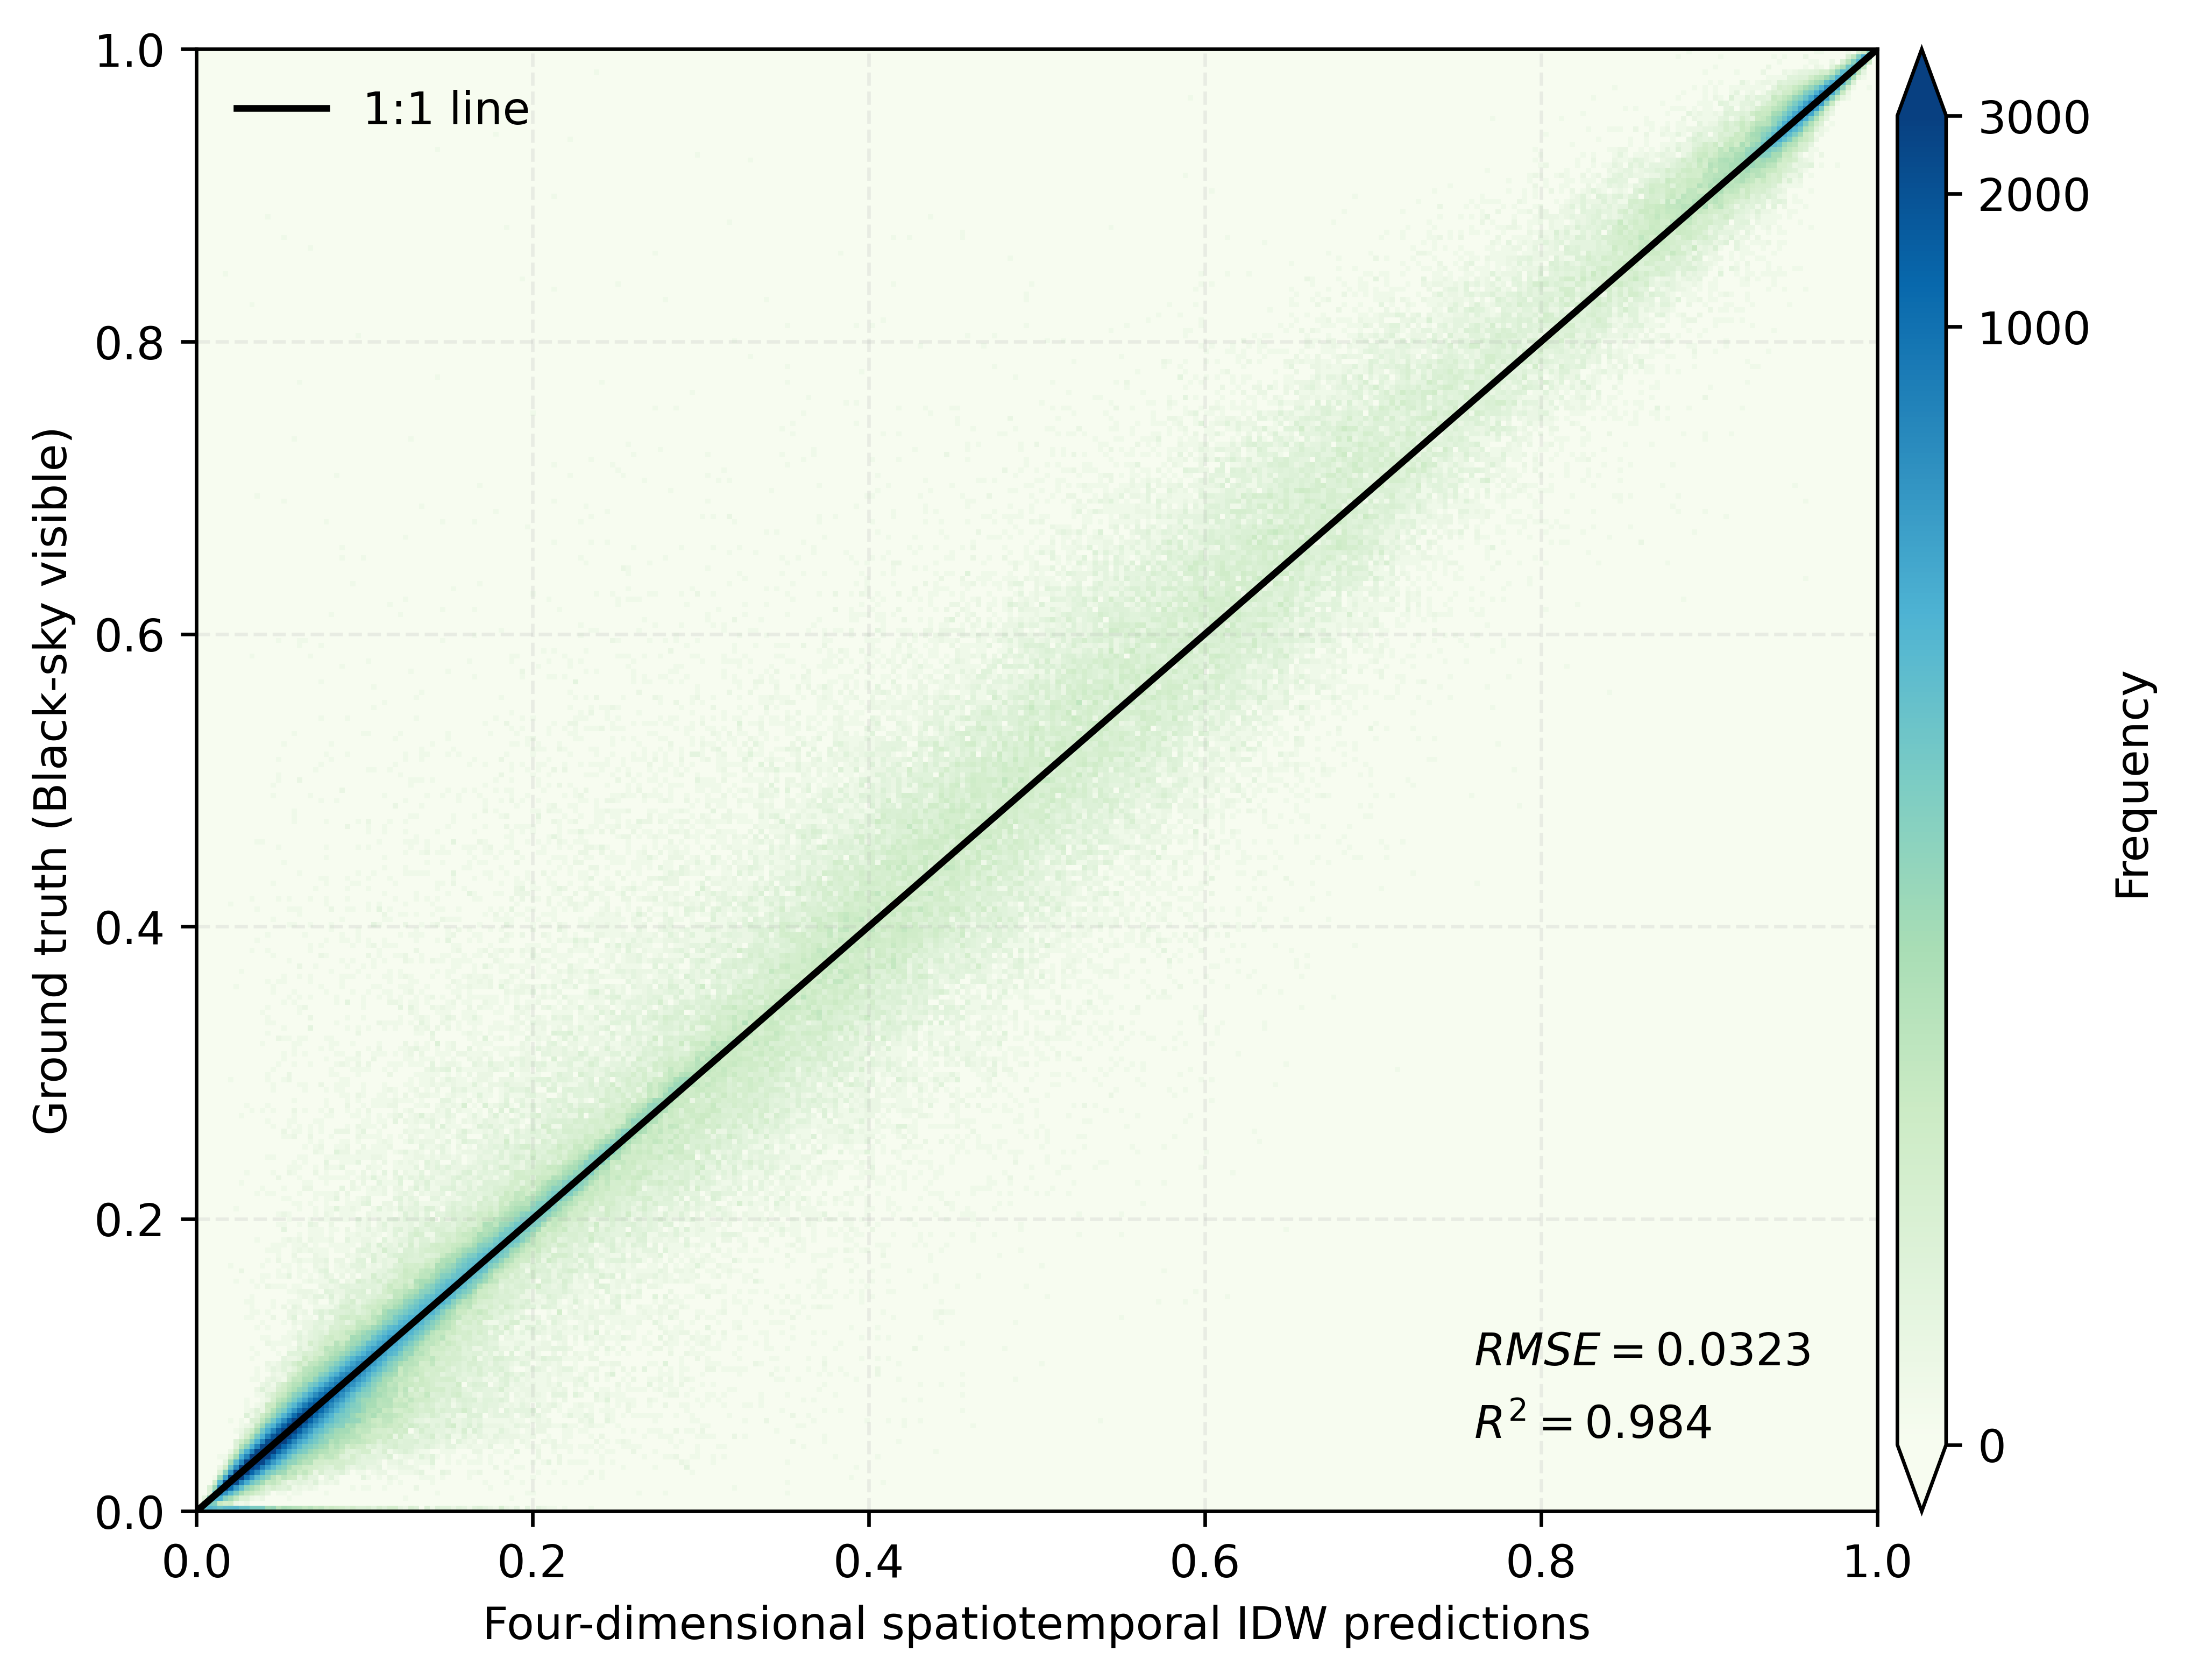

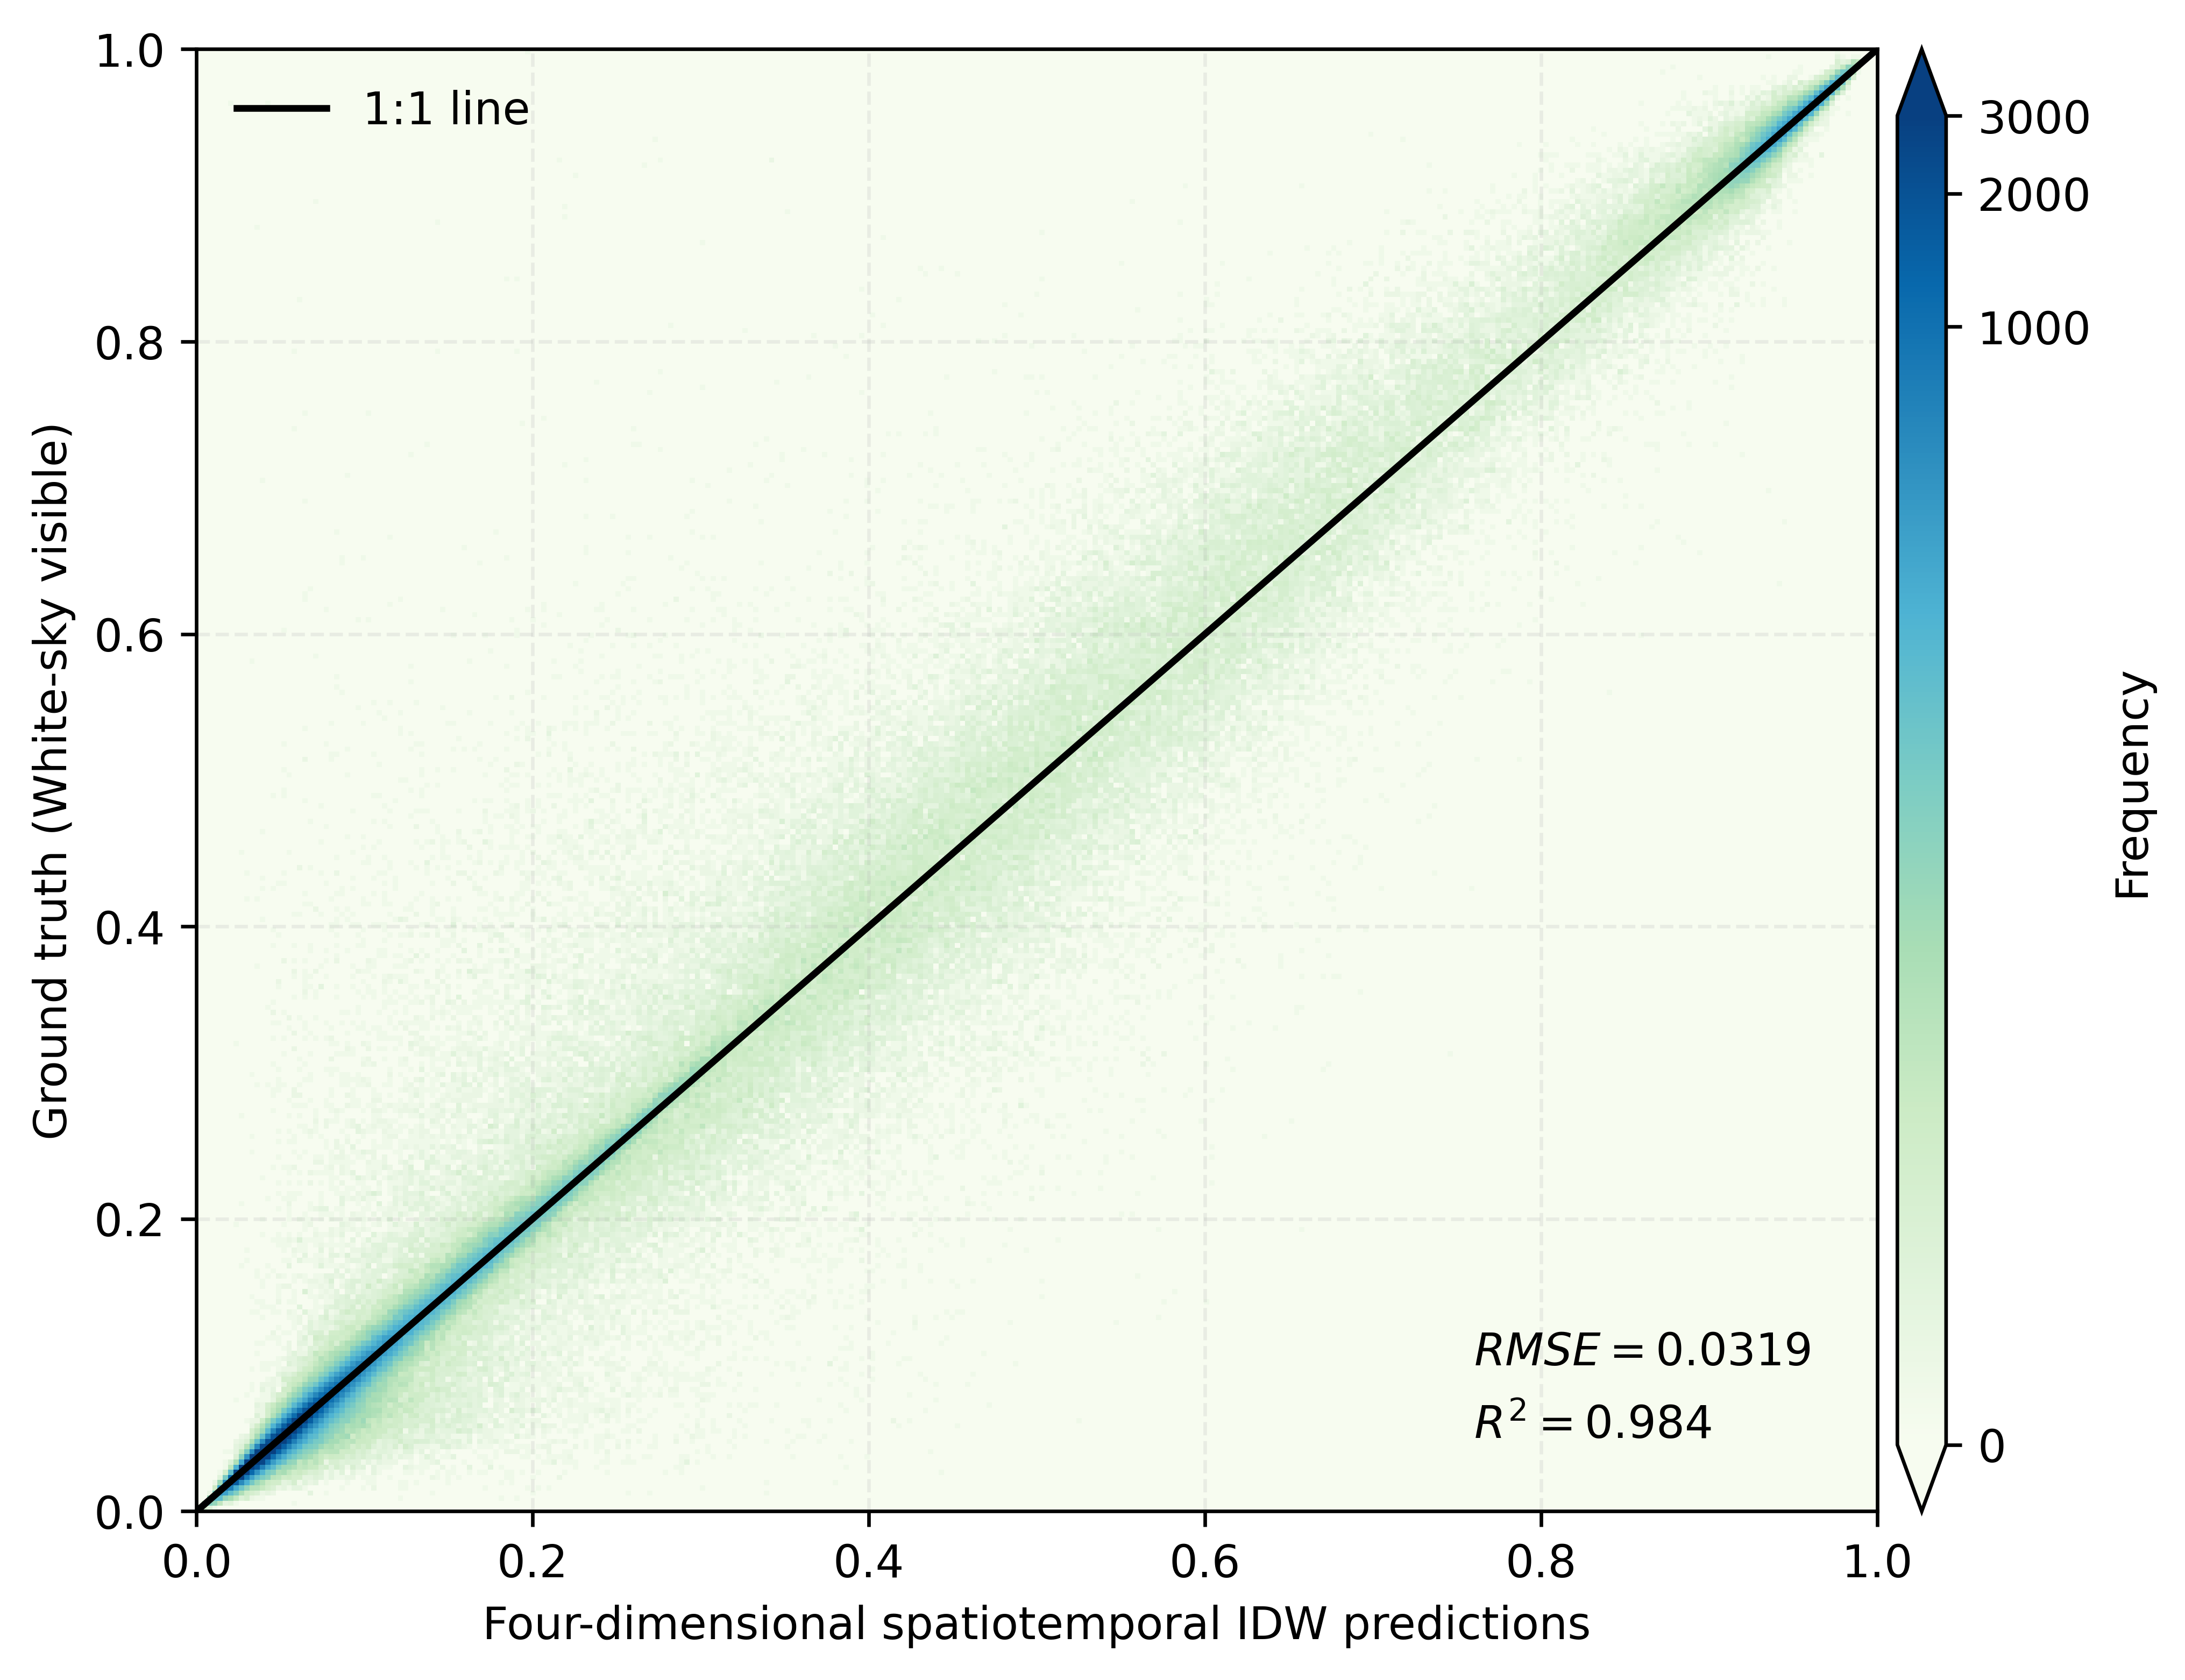

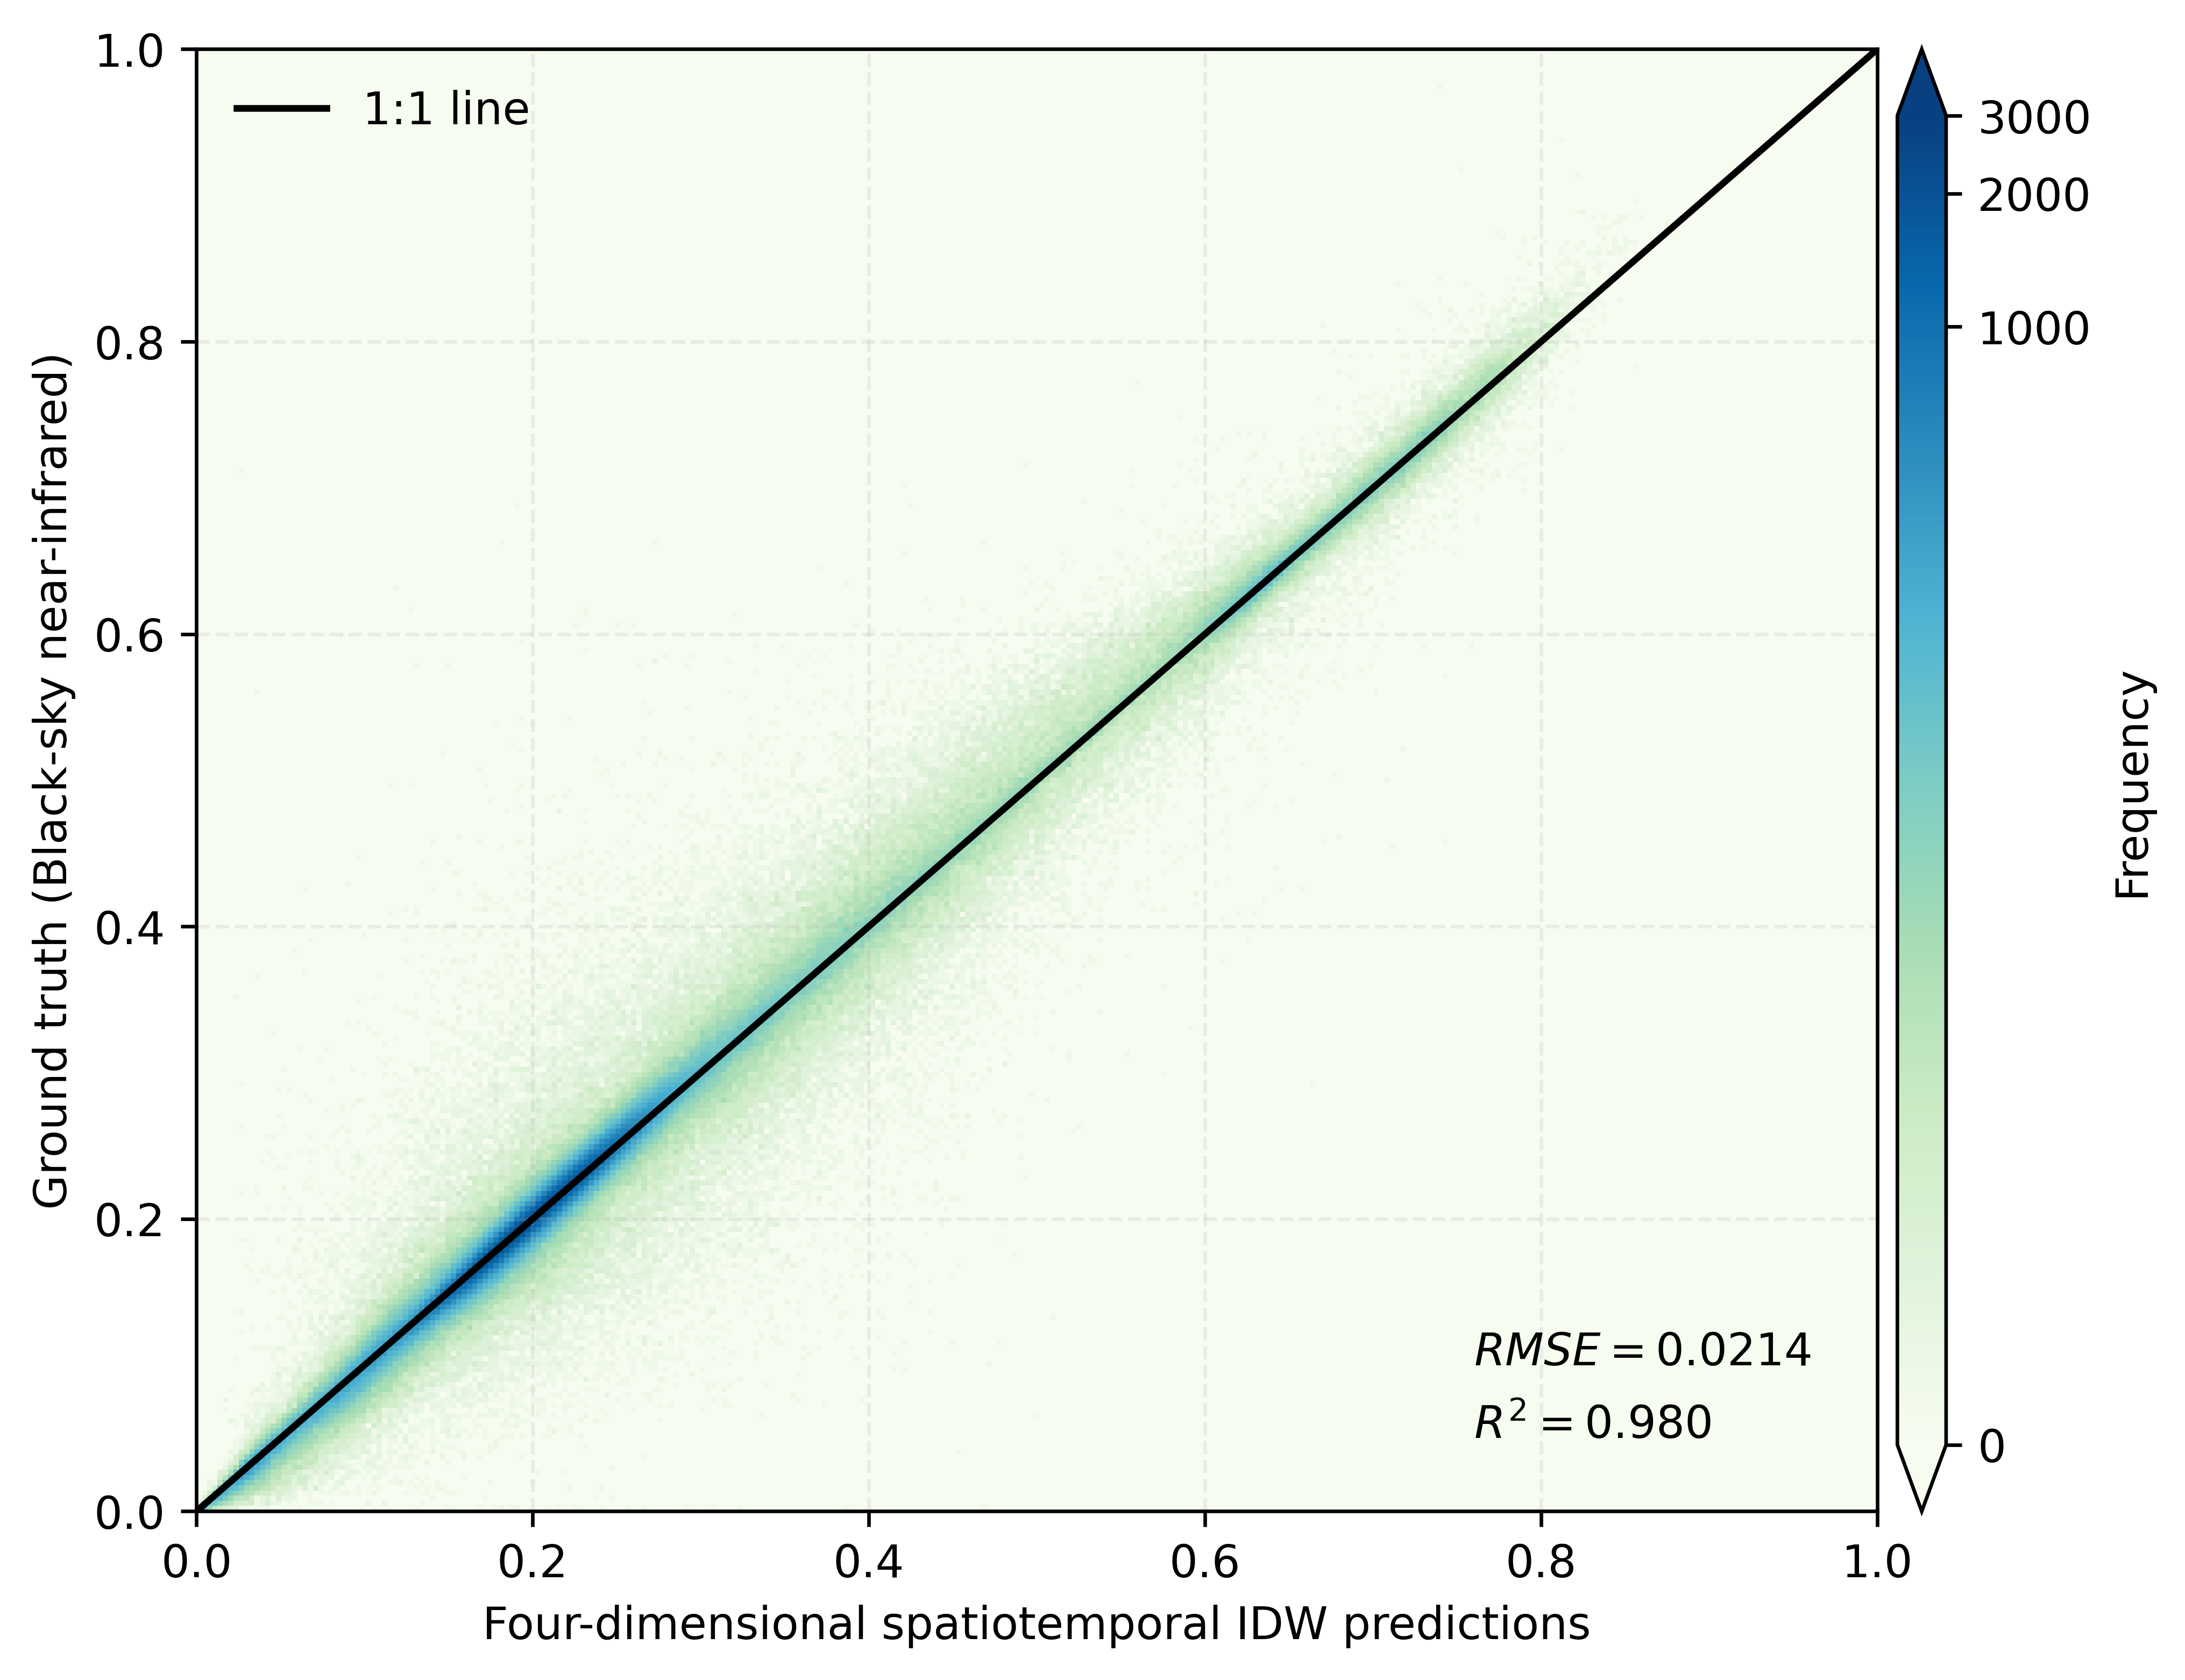

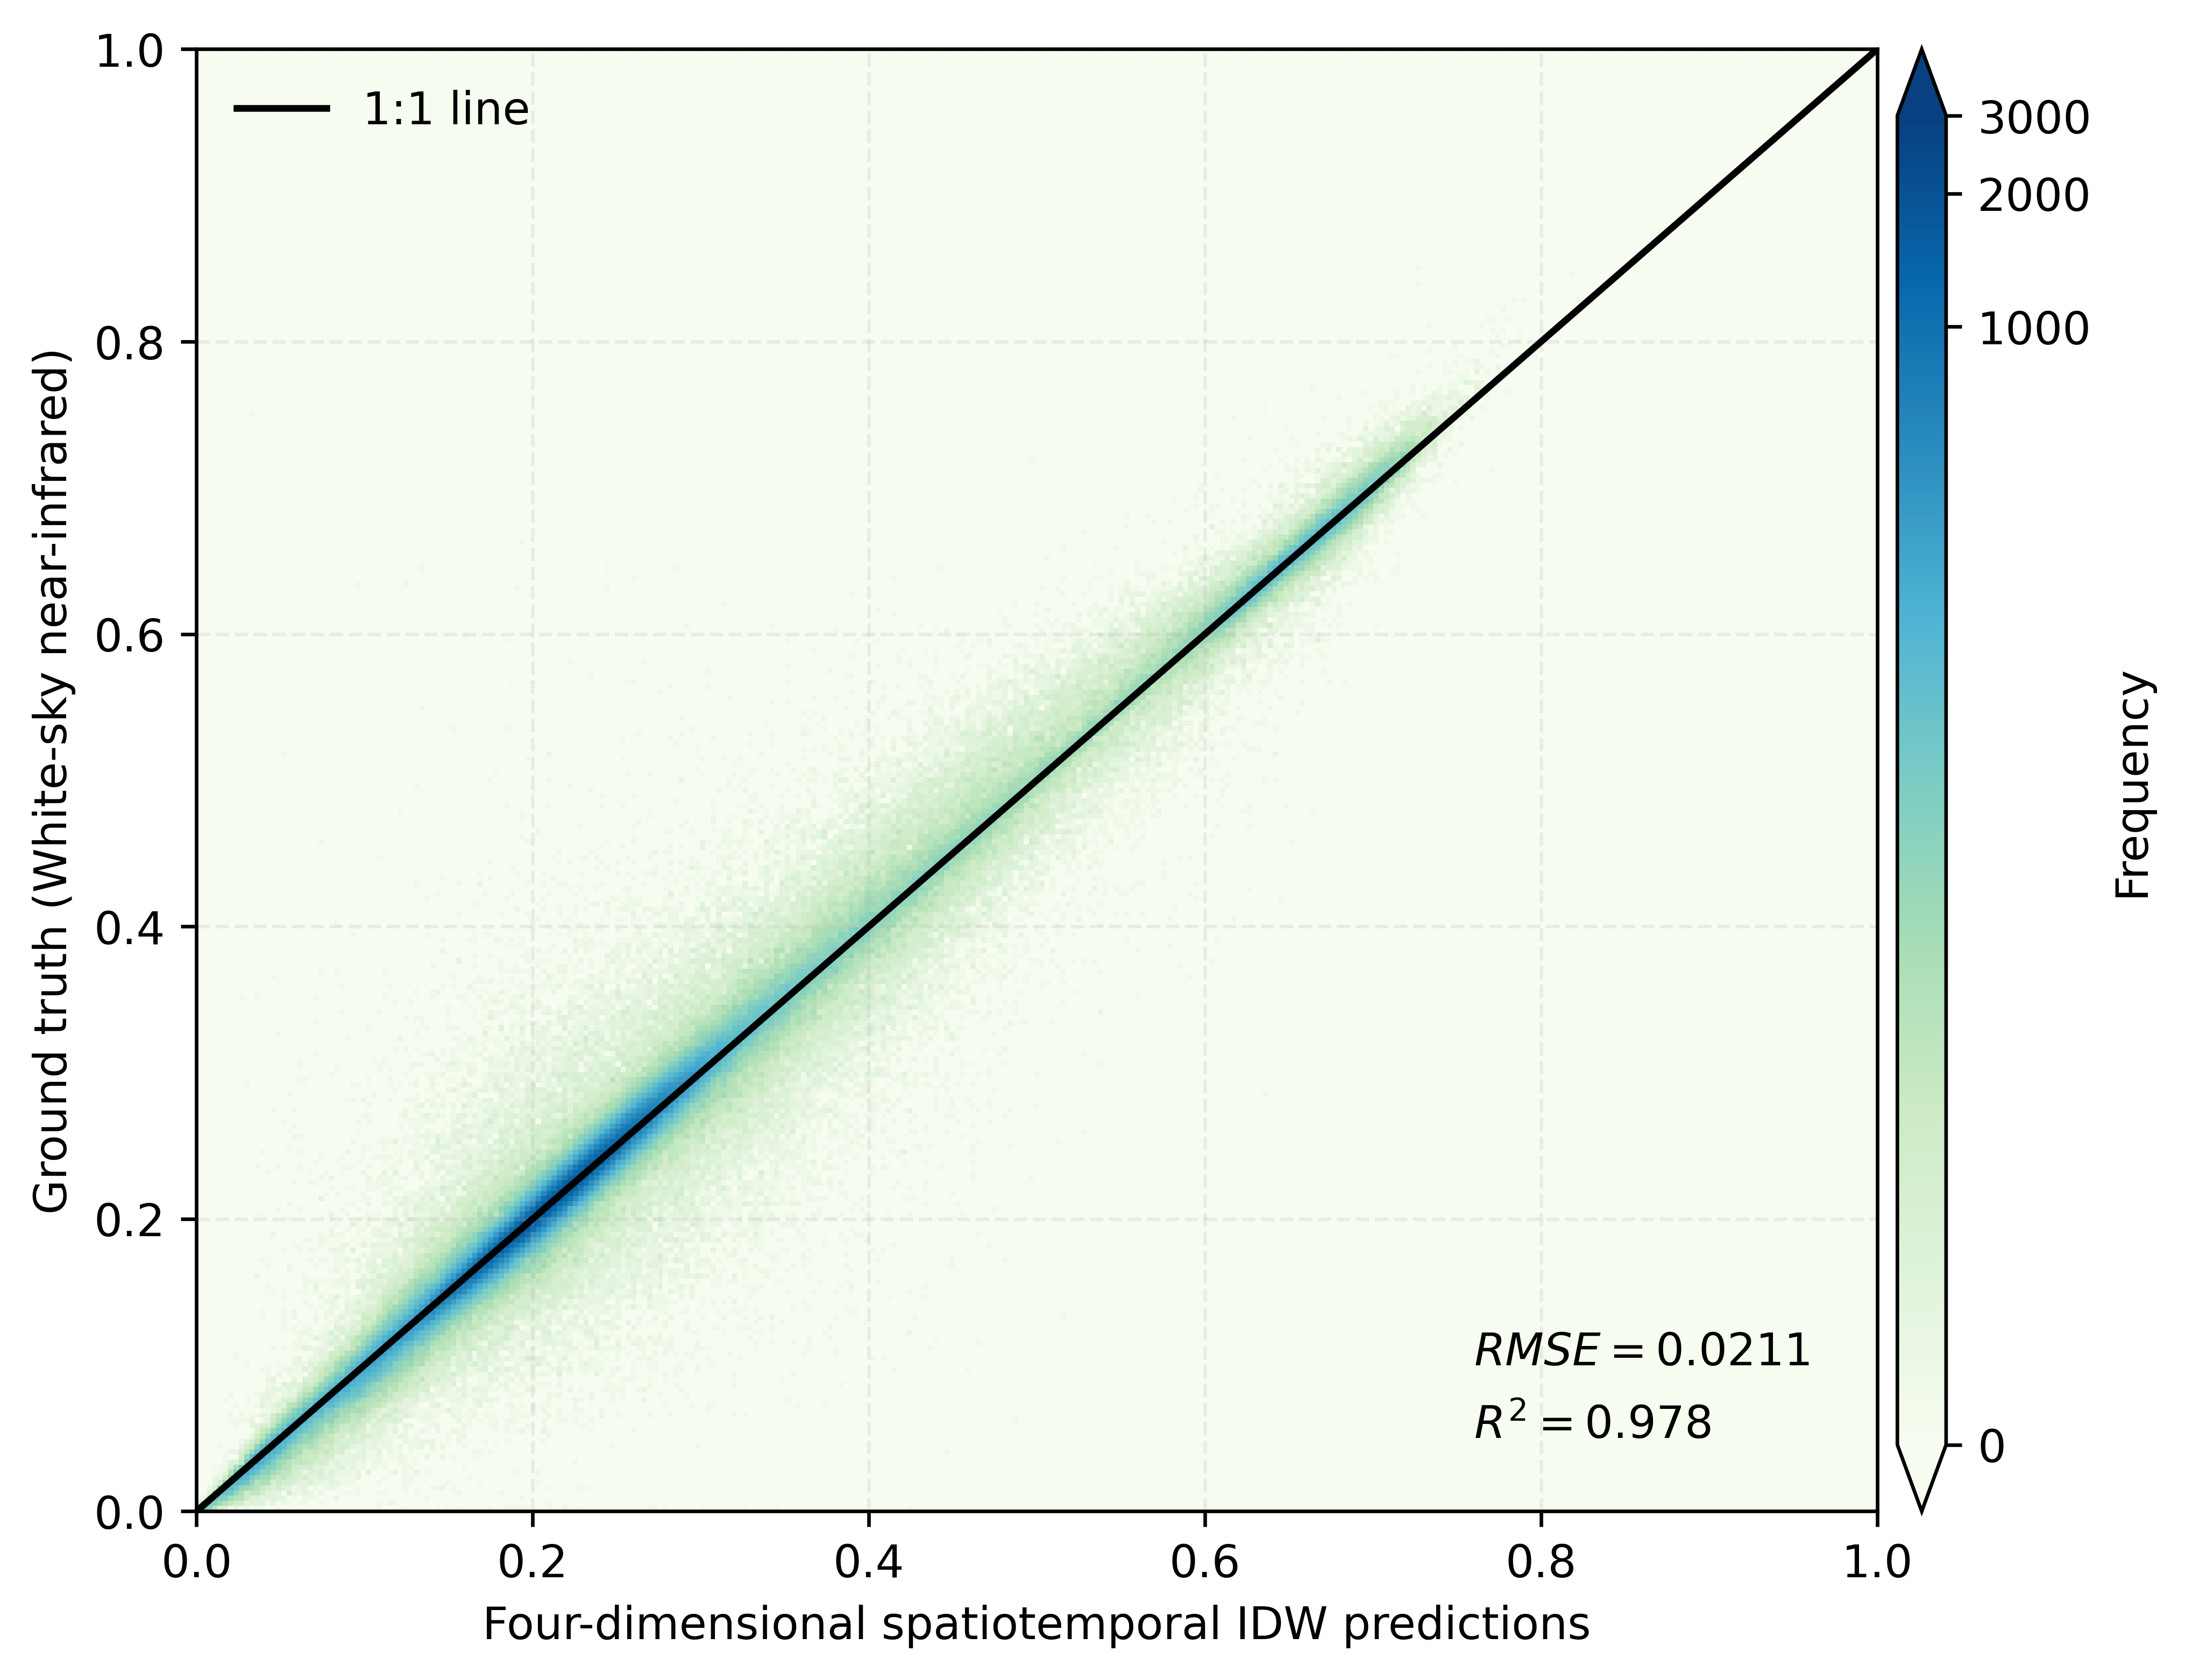

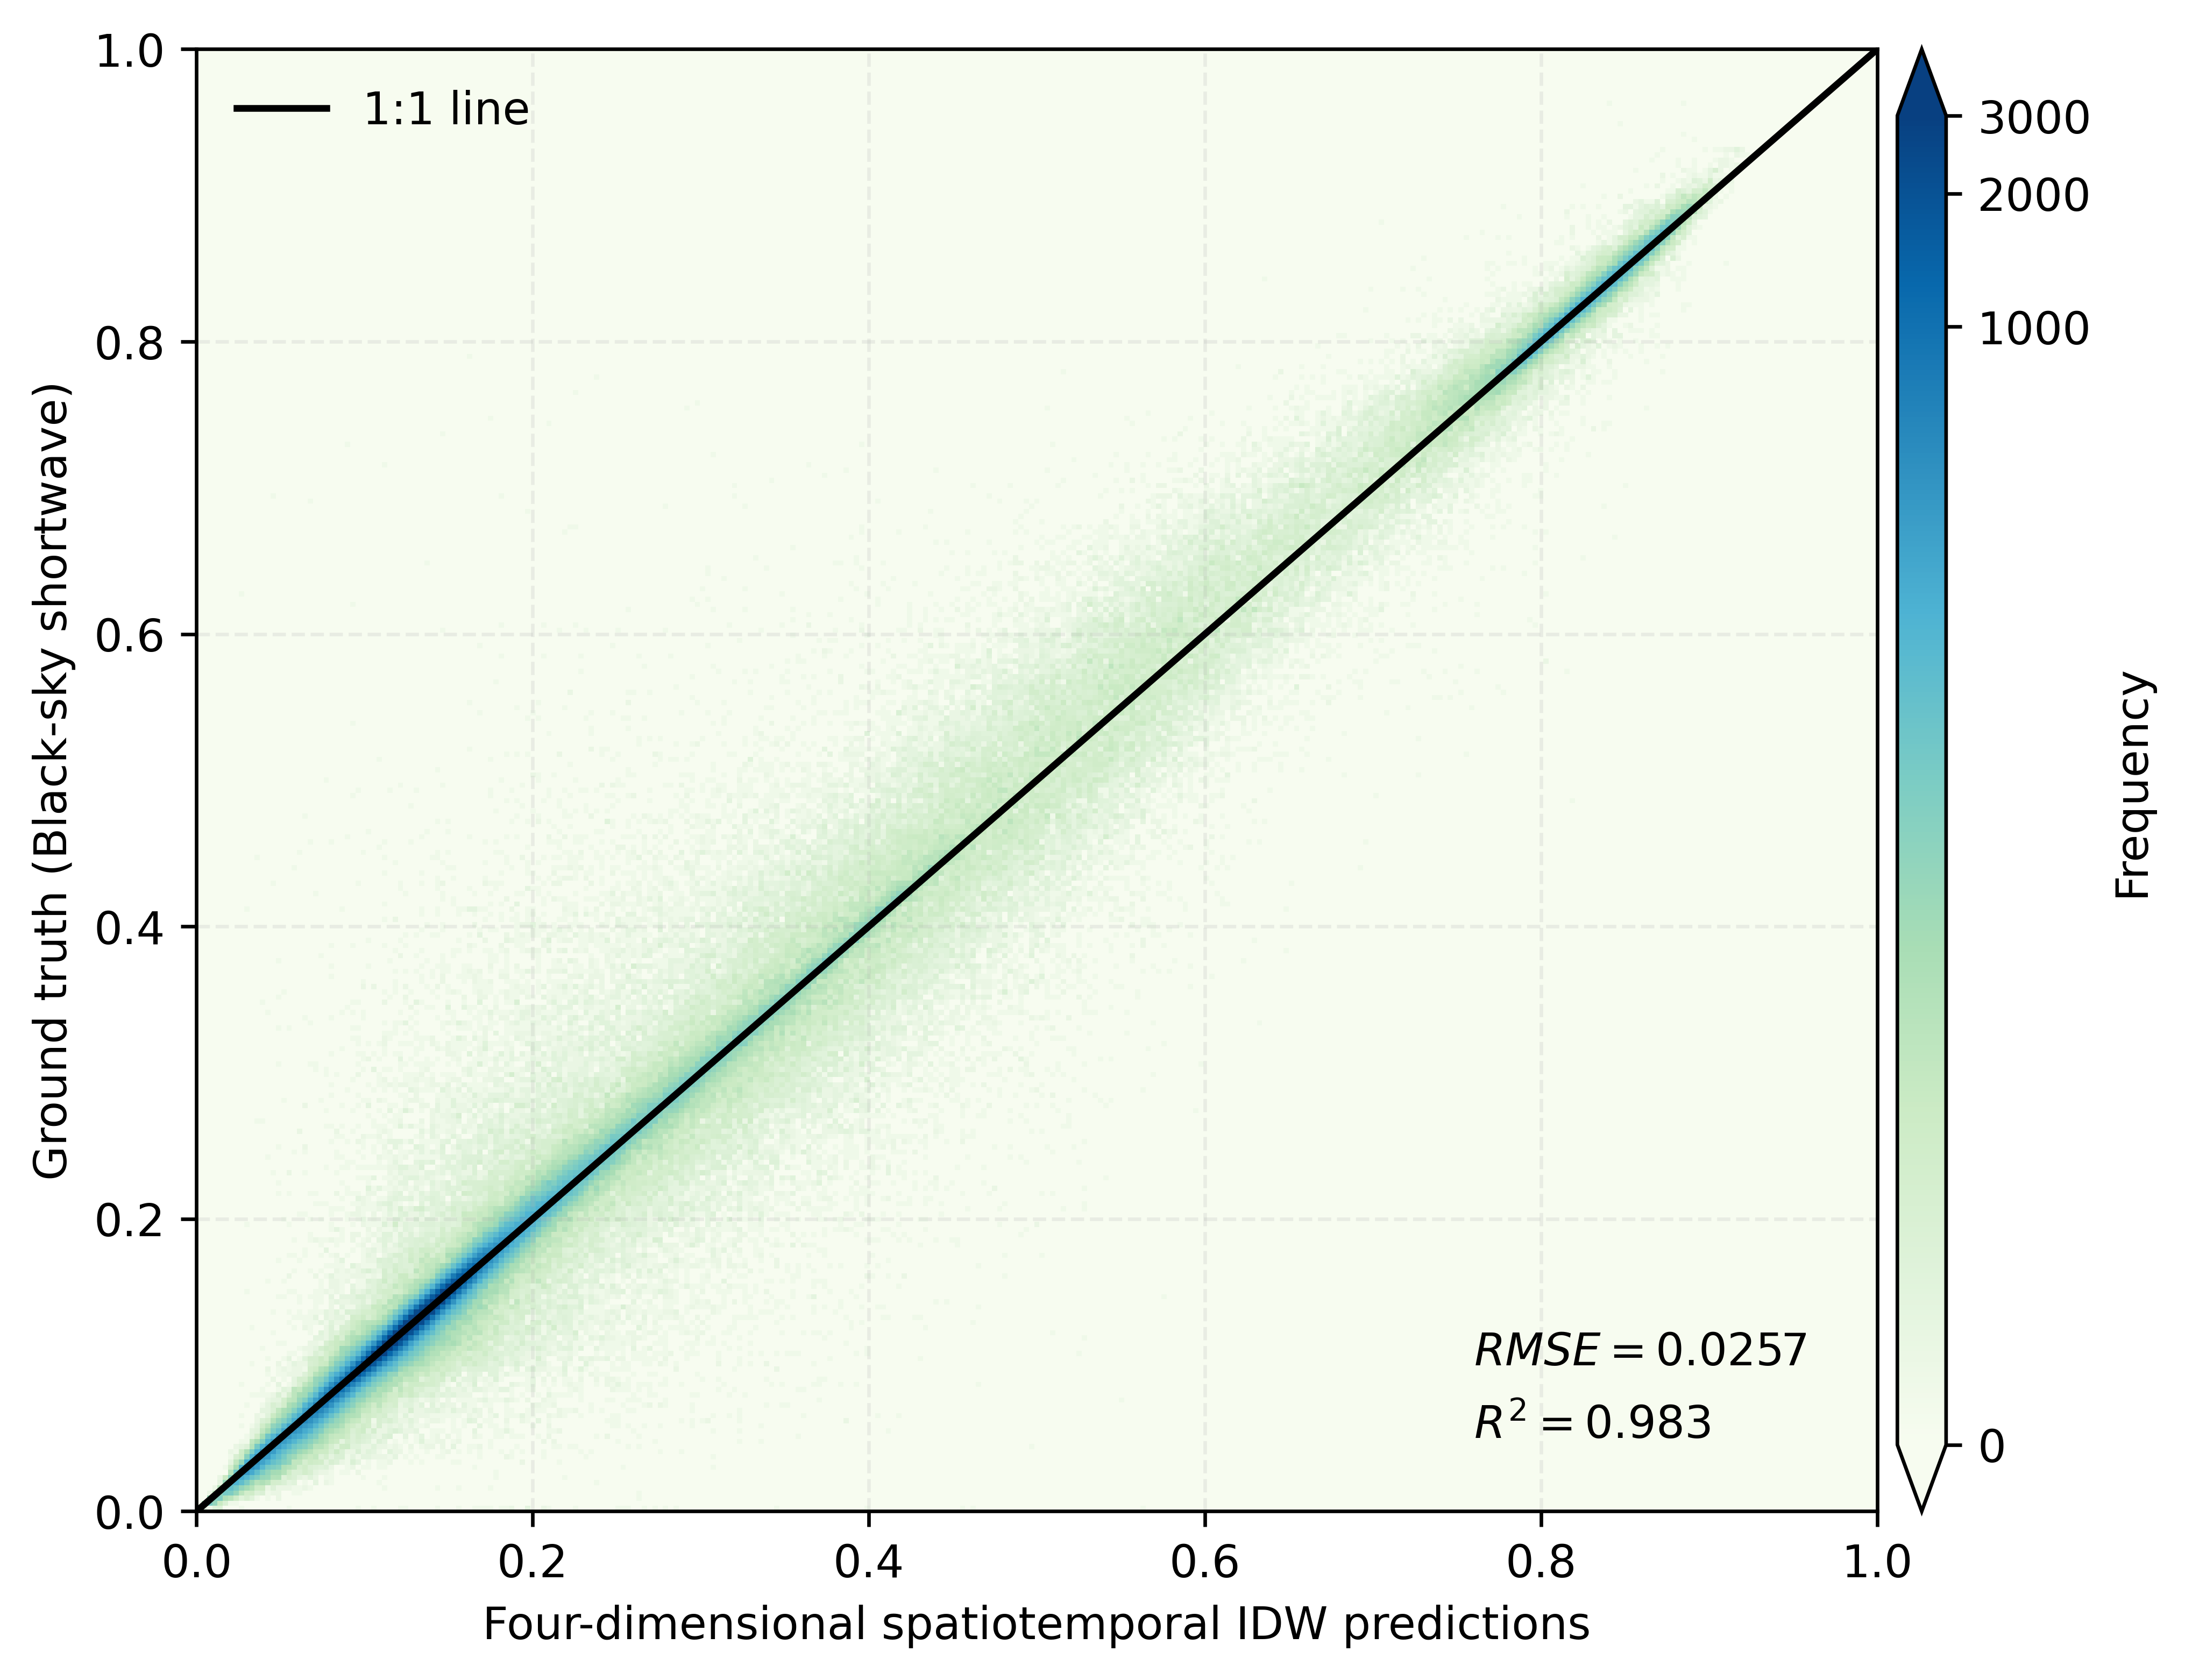

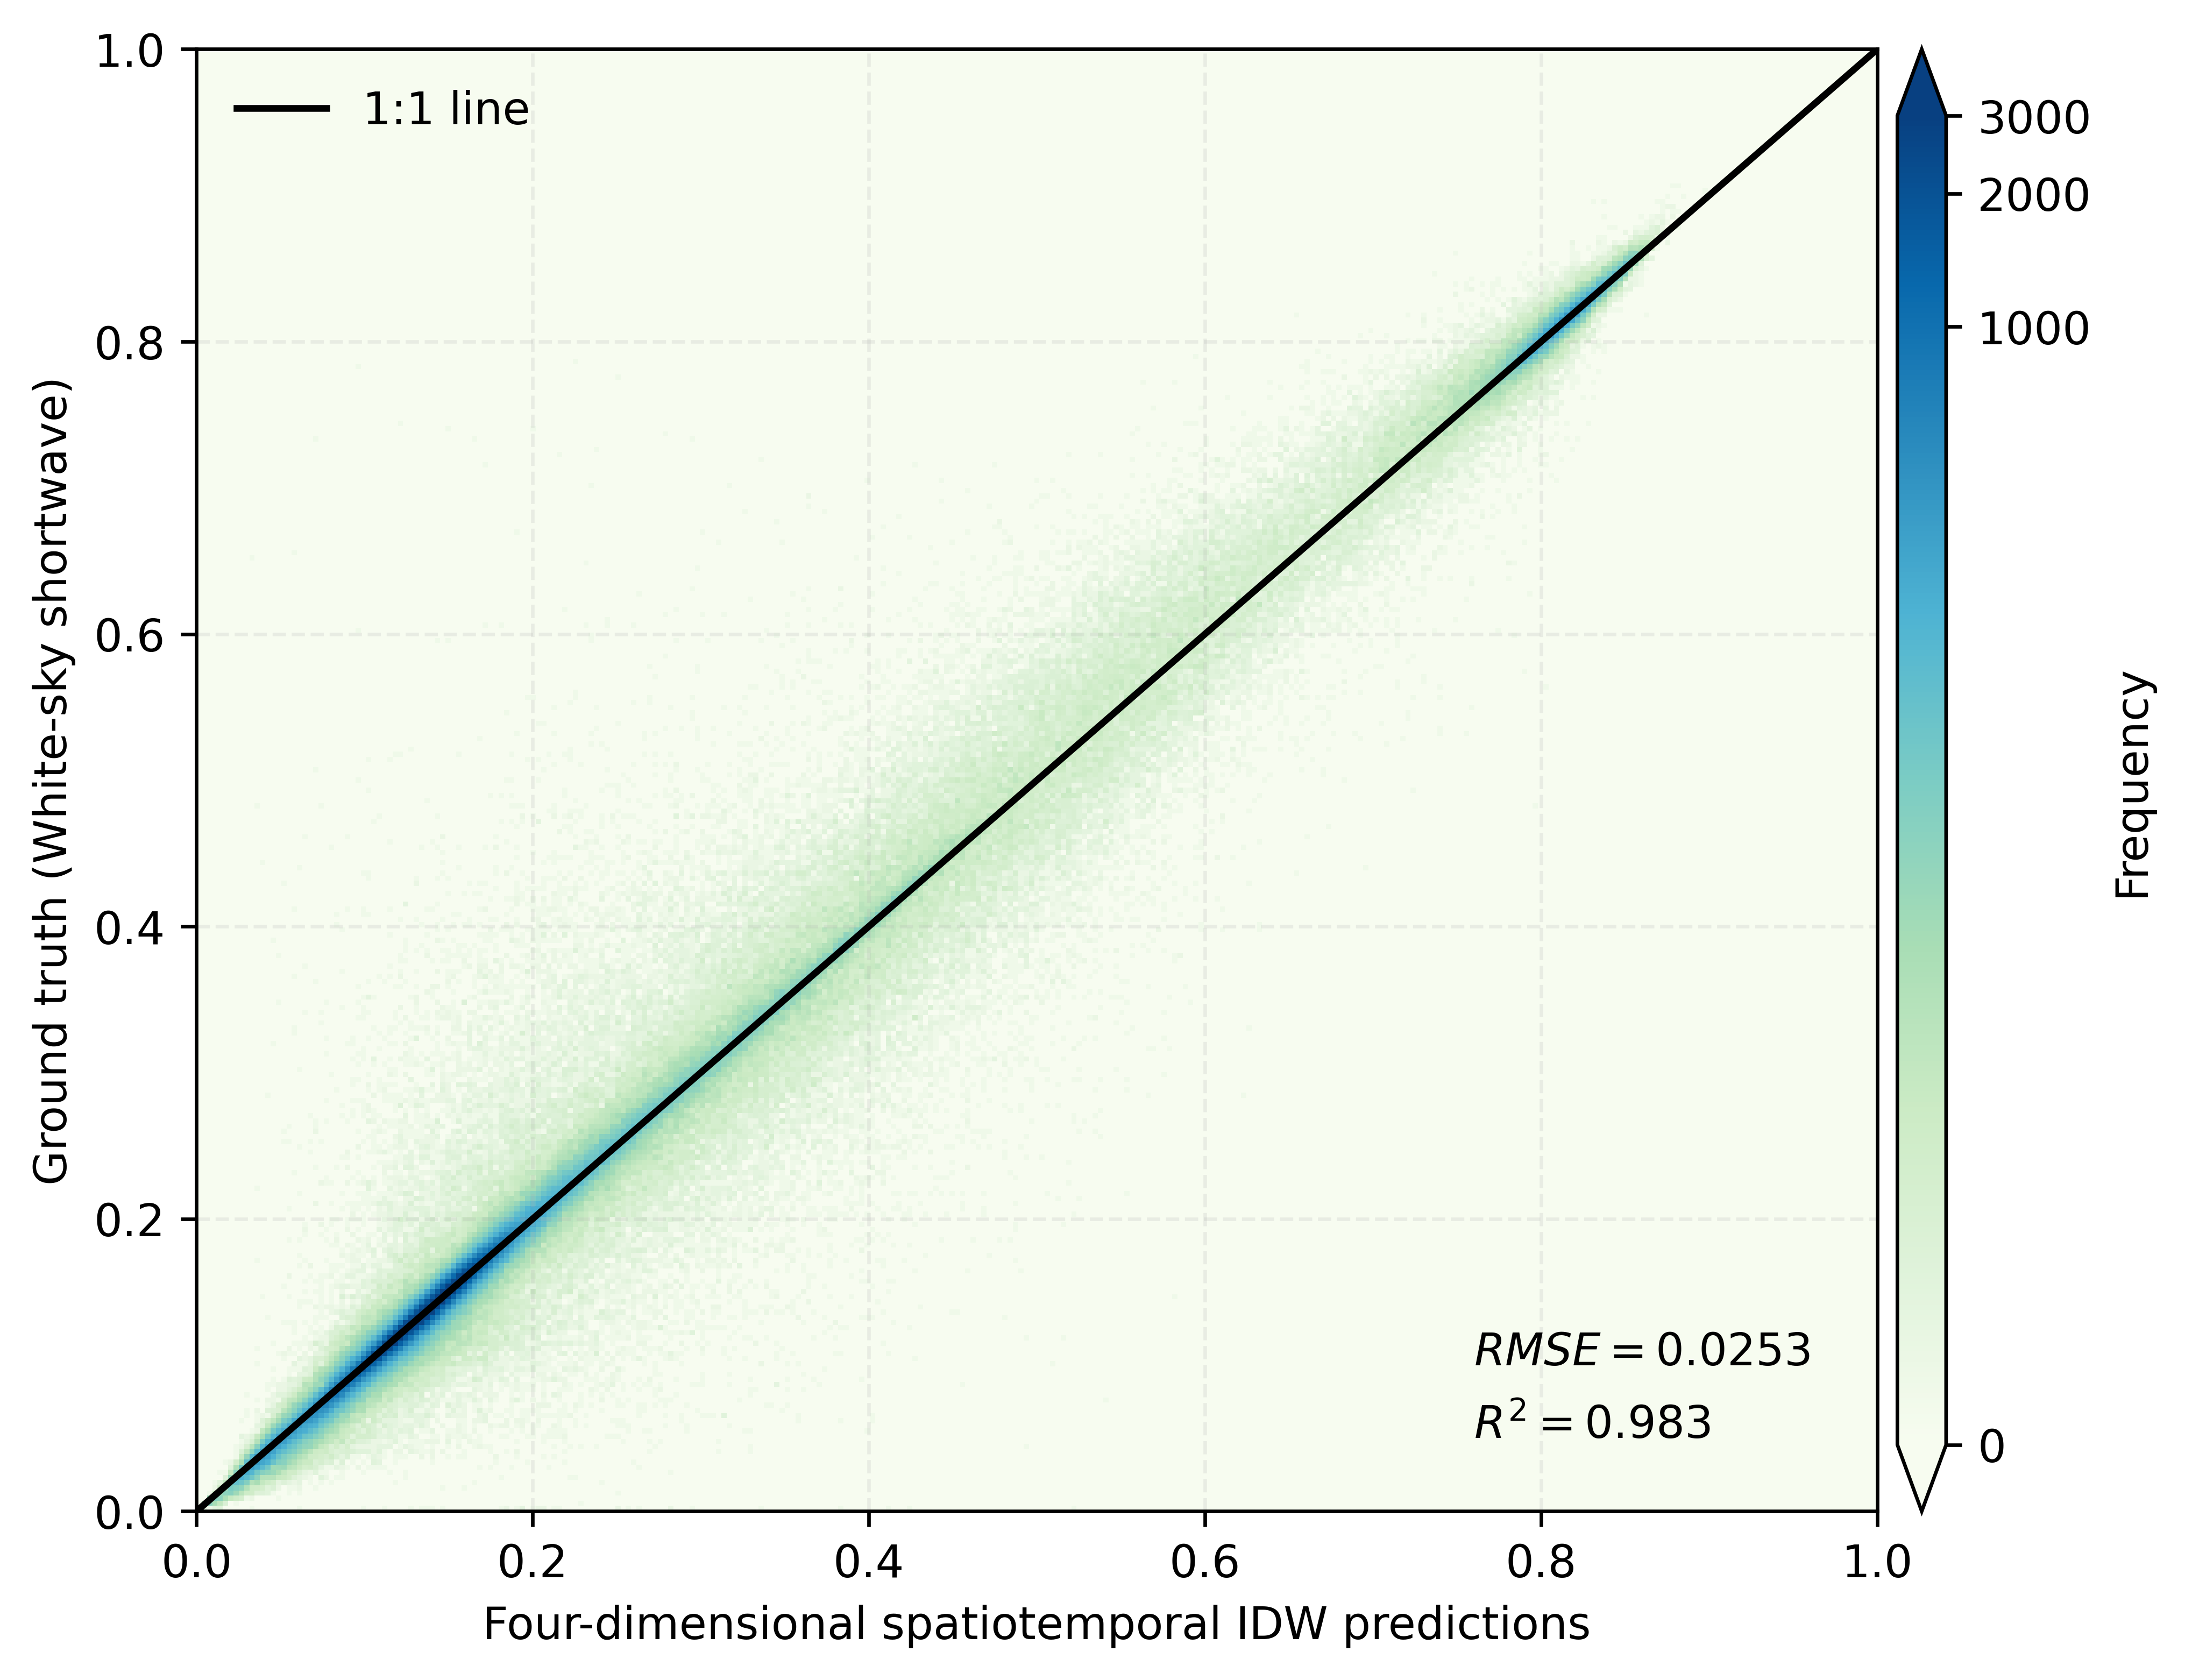

In [13]:
from statistics import mean
for iii in range(1,7):
    plt.rcParams['font.sans-serif']=['Microsoft YaHei'] 
    x,y=np.array(aaa_pd2[f'pred_band{iii}'])/1000,np.array(aaa_pd2[f'main_band{iii}'])/1000
    R2 = r2_score(x,y)
    xy = np.vstack([x, y])
    # z=stats.gaussian_kde(xy)(xy)
    # idx=z.argsort()
    # x, y, z = x.iloc[idx], y.iloc[idx], z[idx]
    def slope(xs, ys):
        m = (((mean(xs) * mean(ys)) - mean(xs * ys)) / ((mean(xs) * mean(xs)) - mean(xs * xs)))
        b = mean(ys) - m * mean(xs)
        return m, b
    k, b = slope(x, y)
    regression_line = []
    for a in range(100000):
        regression_line.append((k * a/100000) + b)
        
    MSE = mean_squared_error(y,x)  
    RMSE = np.power(MSE, 0.5)
    R2 = r2_score(y,x)

    # fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    import mpl_scatter_density
    from astropy.visualization import LogStretch
    from astropy.visualization.mpl_normalize import ImageNormalize
    from matplotlib.ticker import MultipleLocator
    norm = ImageNormalize(vmin=0., vmax=3000, stretch=LogStretch())
    fig = plt.figure(figsize=(8, 6), dpi=600)
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    # scatter = ax.scatter(x, y, marker='o', c=z * 100, edgecolors=None, s=5, cmap='RdBu_r',  alpha=0.8)
    # cbar = plt.colorbar(scatter, shrink=1, orientation='vertical', extend='both', pad=0.01, aspect=30, label='Frequency')
    density = ax.scatter_density(x, y, cmap='GnBu',norm=norm)
    cbar=fig.colorbar(density, shrink=1, orientation='vertical', extend='both', pad=0.01, aspect=30, label='Frequency')
    cbar.ax.yaxis.set_major_locator(MultipleLocator(1000))
    plt.plot([0, 1], [0, 1], 'black', lw=1.5, label='1:1 line') 
    # plt.plot([i/100000 for i in range(100000)], regression_line, 'black', lw=1.5, label='Regression Line')  
    ax.grid(True, linestyle='--', alpha=0.2)


    plt.annotate('$R^2=%.3f$' % R2,(0.76,0.05))
    plt.annotate('$RMSE=%.4f$' % RMSE,(0.76,0.1))
    # plt.text(28,-12.5, '$R^2=%.3f$' % R2)
    # plt.text(28,-27.5, '$RMSE=%.3f$' % RMSE)
    plt.xlabel(r'Four-dimensional spatiotemporal IDW predictions',fontsize=10)
    # plt.ylabel(r'Ground truth (White-sky near-infrared)',fontsize=10)
    wb,bb=bands[iii-1].split('_')[1],bands[iii-1].split('_')[2]
    plt.ylabel(f'Ground truth ({wb} {bb})',fontsize=10)
    plt.axis([0, 1, 0,1])  # 设置线的范围
    ax.legend(loc='upper left', frameon = False)
    plt.savefig(f'./figure/IDW_{wb}_{bb}_kernel.pdf',dpi=600)
    plt.savefig(f'./figure/IDW_{wb}_{bb}_kernel.png',dpi=600)
    plt.show()